In [1]:
import numpy as np
from src.PorfolioOptimizerSA import PortfolioOptimizerSA 

from src.analysis import (
    plot_cvar_history,
    return_rate_influence,
    plot_return_rate_influence,
    plot_weights,
    analyze_different_portfolios,
    plot_regularization_weights,
    probabilities_ifluence,
    examine_num_of_scenarios_influence
)

/Users/julia/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


### Losowanie scenariuszy
Dodajemy możliwość generowania scenariuszy zmiany cen akcji. Cena akcji wówczas  $S_T = \alpha S_0$, gdzie $\alpha$ oznacza:
- duży spadek: $\alpha \sim \mathcal{N}(0.3, 0.1)$
- spadek: $\alpha \sim \mathcal{N}(0.9, 0.1)$  
- brak zmiany: $\alpha \sim \mathcal{N}(1, 0.1)$  
- wzrost: $\alpha \sim \mathcal{N}(1.2, 0.2)$  
- duży wzrost: $\alpha \sim \mathcal{N}(1.5, 1)$

Wybór współczynnika $\alpha$ odbywa się losowo z powyższych rozkładów z prawdopodobieństwami $[0.1, 0.2, 0.4, 0.2, 0.1]$. Dodatkowo, zawsze wymuszamy, by przynajmniej jedna akcja w scenariuszu miała wzrost (aby możliwe było osiagnięcie stopy zwrotu).

In [2]:
def generate_scenarios(S_0, number_of_scenarios=1000):
    """
    Generuje losowe scenariusze na podstawie stanu początkowego.
    
    """
    
    p = np.array([0.1, 0.2, 0.4, 0.2, 0.1])
    scenarios = np.zeros((number_of_scenarios, len(S_0)))
    for i in range(number_of_scenarios):
        coefs = [np.random.normal(0.3, 0.1), 
                 np.random.normal(0.9, 0.1),
                 np.random.normal(1, 0.1),
                 np.random.normal(1.2, 0.2),
                 np.random.normal(1.5, 1)]
        chosen = np.random.choice(coefs, size=len(S_0), p=p)
        
        # ensure at least one growth
        if not np.any(np.array(chosen) > 1):
            idx = np.random.randint(len(S_0))
            chosen[idx] = np.random.uniform(1.01, 1.1)
        
        S_T = S_0 * chosen
        scenarios[i] = S_T
    
    return scenarios
    


prawdopodobieństwo występienia i-tego scenariusza $p_i$ nie jest jednostajne - zakładamy pewną wiedzę ekspercką o rynku

In [3]:
# stan początkowy
S_0 = np.array([100, 100, 100, 100, 100])

# stany
S_T = generate_scenarios(S_0, number_of_scenarios=1000)

# prawdopodobieństwa
probabilities = 1 / np.arange(1, S_T.shape[0] + 1)
# prawdopodobieństwa znormalizowane
probabilities /= probabilities.sum()

probabilities_uniform = np.ones(S_T.shape[0]) / S_T.shape[0]

# poziom ufności
alpha = 0.95

# wartość portfela na początku
V_0 = 10000

# stopa zwrotu
return_rate = 0.05

# parametry symulowanego wyżarzania
T_0 = 1000  # początkowa temperatura
T_f = 0.00001  # temperatura końcowa
max_iter = 1000  # maksymalna liczba iteracji
step_size = 0.1  # wielkość kroku
annealing_rate = 0.99  # współczynnik chłodzenia

### Proces optymalizacji

/Users/julia/Desktop/semestr-6/azlm/projekt/MeanVariancePortfolioMC/src/PorfolioOptimizerSA.py:152: RuntimeWarning: overflow encountered in exp
  p_accept = min(1, np.exp(-delta_CVaR / T))


Ścieżka 1: Końcowe CVaR = 6781.7201
Ścieżka 2: Końcowe CVaR = 6801.0993
Ścieżka 3: Końcowe CVaR = 6805.5366
Ścieżka 4: Końcowe CVaR = 6821.8604
Ścieżka 5: Końcowe CVaR = 6790.5195
Ścieżka 6: Końcowe CVaR = 6783.8819
Ścieżka 7: Końcowe CVaR = 6789.8159


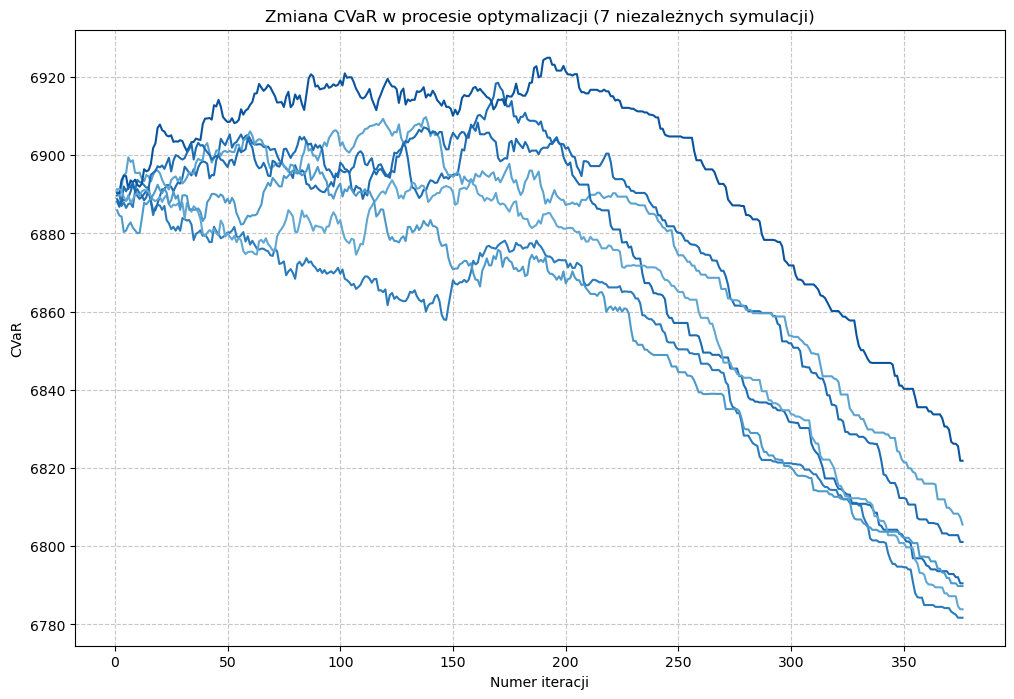

In [4]:
plot_cvar_history(T_0 = T_0,
                  T_f = T_f,
                  max_iter = max_iter,
                  step_size = step_size,
                  annealing_rate = annealing_rate,
                  probabilities = probabilities,
                  alpha = alpha,
                  S_0 = S_0,
                  S_T = S_T,
                  V_0 = V_0,
                  return_rate = return_rate,
                  n_paths=7)

Ścieżka 1: Końcowe CVaR/V0 = 0.6790
Ścieżka 2: Końcowe CVaR/V0 = 0.6773
Ścieżka 3: Końcowe CVaR/V0 = 0.6745
Ścieżka 4: Końcowe CVaR/V0 = 0.6827
Ścieżka 5: Końcowe CVaR/V0 = 0.6834
Ścieżka 6: Końcowe CVaR/V0 = 0.6805
Ścieżka 7: Końcowe CVaR/V0 = 0.6829


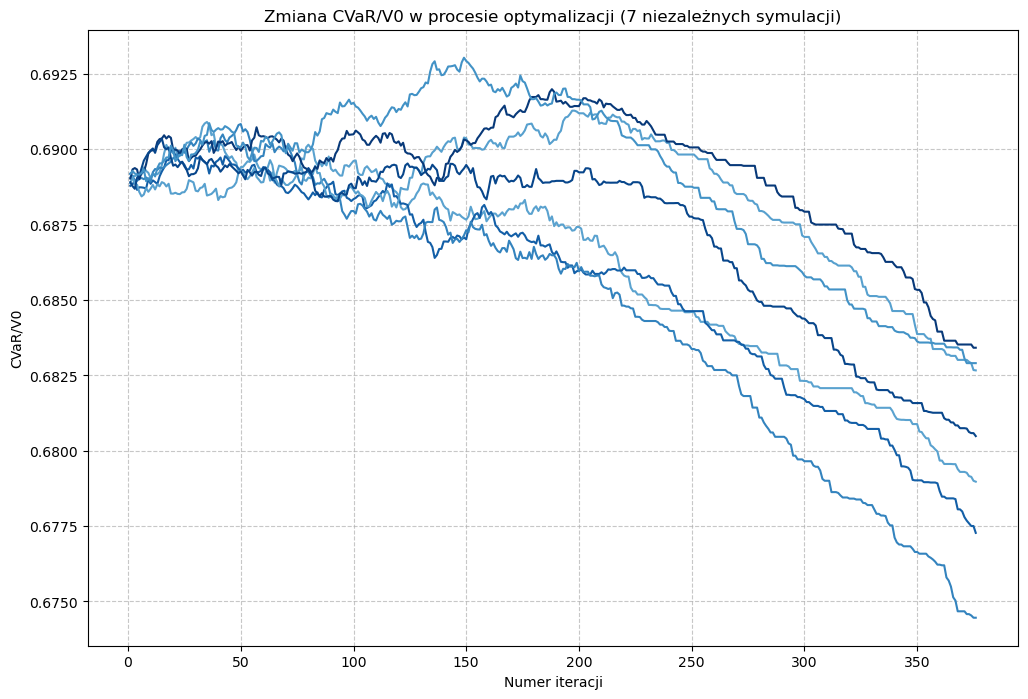

In [5]:
plot_cvar_history(T_0 = T_0,
                  T_f = T_f,
                  max_iter = max_iter,
                  step_size = step_size,
                  annealing_rate = annealing_rate,
                  probabilities = probabilities,
                  alpha = alpha,
                  S_0 = S_0,
                  S_T = S_T,
                  V_0 = V_0,
                  return_rate = return_rate,
                  n_paths=7,
                  relative=True)

### Wpływ stopy zwrotu

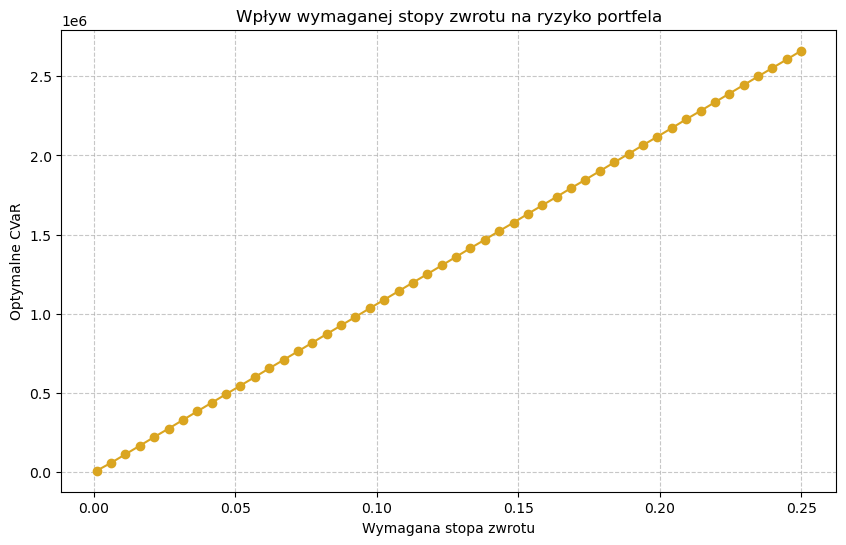

In [6]:
res = return_rate_influence(T_0=T_0,
                            T_f=T_f,
                            max_iter=max_iter,
                            step_size=step_size,
                            annealing_rate=annealing_rate,
                            probabilities=probabilities_uniform,
                            alpha=alpha,
                            S_0=S_0,
                            S_T=S_T,
                            V_0=V_0,
                            return_rates=np.linspace(0.001, 0.25, 50))
plot_return_rate_influence(res)

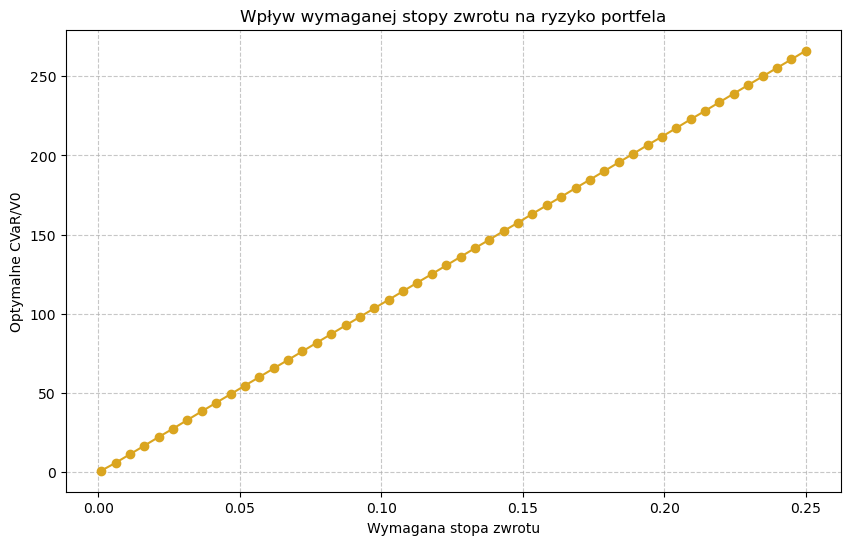

In [7]:
plot_return_rate_influence(res, relative=True, V_0=V_0)

### Zmiana ilości akcji w portfelu w procesie optymalizacji

Optymalny portfel: [34 25 10  2 29]
Wartość CVaR: 4064.4082033944765


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

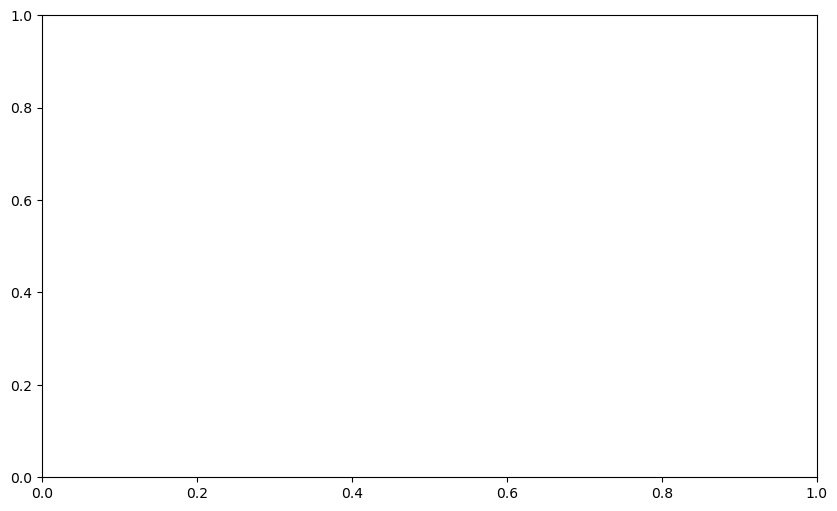

In [8]:
optimizer = PortfolioOptimizerSA(
    T_0=T_0,
    T_f=T_f,
    max_iter=max_iter,
    step_size=step_size,
    annealing_rate=annealing_rate,
    probabilities=probabilities,
    alpha=alpha,
    S_0=S_0,
    S_T=S_T,
    V_0=V_0,
    return_rate=return_rate, 
    initial_portfolio=np.array([10, 20, 30, 40, 50])
)
optimizer.optimize()

optimal_portfolio = optimizer.x
optimal_CVaR = optimizer.calculate_CVaR(optimal_portfolio)

print("Optymalny portfel:", optimal_portfolio)
print("Wartość CVaR:", optimal_CVaR)

plot_weights(optimizer, './visualizations/weights_gen.gif', plot_every_k_iterations=5, fps=20)

### Wpływ wyboru początkowego portfela

In [8]:
analyze_different_portfolios(
    T_0=T_0,
    T_f=T_f,
    max_iter=max_iter,
    step_size=step_size,
    annealing_rate=annealing_rate,
    probabilities=probabilities,
    alpha=alpha,
    S_0=S_0,
    S_T=S_T,
    V_0=V_0,
    return_rate=return_rate,
    initial_portfolios=[np.array([10, 20, 30, 40, 50]), np.array([5, 15, 25, 35, 45]), np.array([20, 30, 40, 50, 60]),
                        np.array([0, 0, 0, 0, 100]), np.array([100, 100, 100, 100, 100]), np.array([1000, 1000, 1000, 1000, 1000])],
)

Nr   Portfel początkowy                       Portfel optymalny                        CVaR           
------------------------------------------------------------------------------------------------------
1    [10 20 30 40 50]                         [-4 73 10 21  0]                         6147.175262    
2    [ 5 15 25 35 45]                         [ 5 81  2 12  0]                         6337.551512    
3    [20 30 40 50 60]                         [-15  67  22  26   0]                    6165.873230    
4    [  0   0   0   0 100]                    [-23  91   0   0  32]                    7022.276029    
5    [100 100 100 100 100]                    [-61  63  36  28  34]                    8736.542682    
6    [1000 1000 1000 1000 1000]               [-1958  -752   944   927   939]          254420.430241  


In [9]:
analyze_different_portfolios(
    T_0=T_0,
    T_f=T_f,
    max_iter=max_iter,
    step_size=step_size,
    annealing_rate=annealing_rate,
    probabilities=probabilities,
    alpha=alpha,
    S_0=S_0,
    S_T=S_T,
    V_0=V_0,
    return_rate=return_rate,
    initial_portfolios=[np.array([10, 20, 30, 40, 50]), np.array([5, 15, 25, 35, 45]), np.array([20, 30, 40, 50, 60]),
                        np.array([0, 0, 0, 0, 100]), np.array([100, 100, 100, 100, 100]), np.array([1000, 1000, 1000, 1000, 1000])],
    
)

Nr   Portfel początkowy                       Portfel optymalny                        CVaR           
------------------------------------------------------------------------------------------------------
1    [10 20 30 40 50]                         [ 3 78  3 16  0]                         6261.641059    
2    [ 5 15 25 35 45]                         [ 4 80  3 13  0]                         6304.571817    
3    [20 30 40 50 60]                         [-5 67  8 30  0]                         6029.540489    
4    [  0   0   0   0 100]                    [-22  91   0   0  31]                    6989.999855    
5    [100 100 100 100 100]                    [-75  46  48  49  32]                    10575.619119   
6    [1000 1000 1000 1000 1000]               [-1962  -761   952   937   934]          255205.833392  


### Regularyzacja

/Users/julia/Desktop/semestr-6/azlm/projekt/MeanVariancePortfolioMC/src/PorfolioOptimizerSA.py:152: RuntimeWarning: overflow encountered in exp
  p_accept = min(1, np.exp(-delta_CVaR / T))


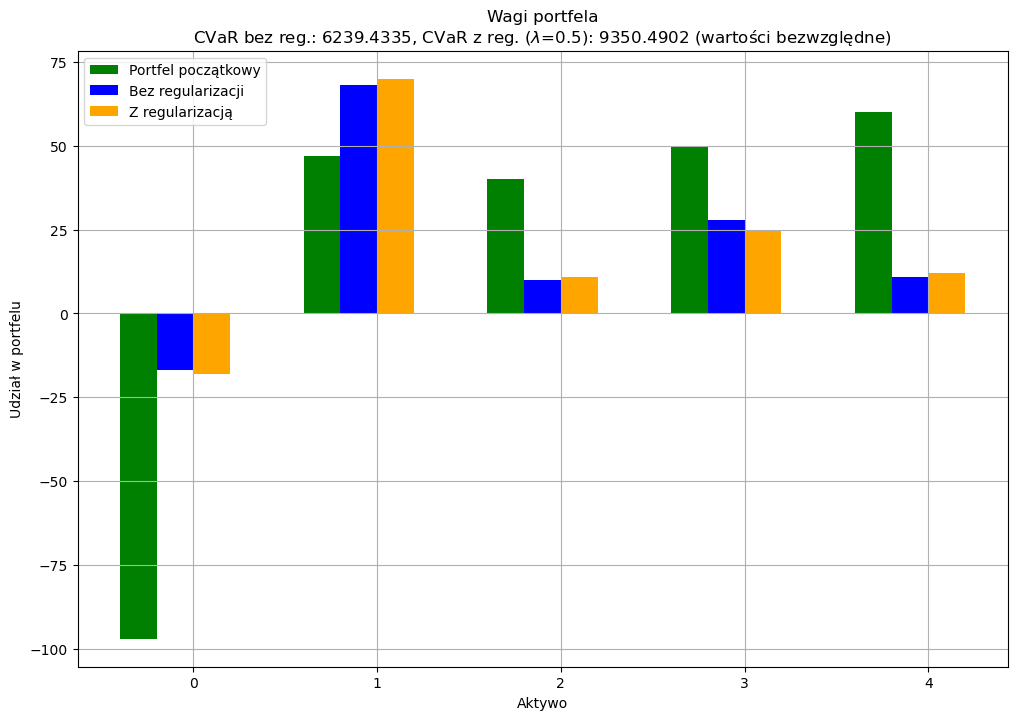

CVaR bez regularizacji: 6239.43
CVaR z regularizacją ($\lambda$=0.5): 9350.49


In [10]:
plot_regularization_weights(T_0=T_0,
                             T_f=T_f,
                            max_iter=max_iter,
                            step_size=step_size,
                            annealing_rate=annealing_rate,
                            probabilities=probabilities,
                            alpha=alpha,
                            S_0=S_0,
                            S_T=S_T,
                            V_0=V_0,
                            return_rate=return_rate,
                            regularization_lambda=0.5,
                            initial_portfolio=np.array([20, 30, 40, 50, 60]),)

/Users/julia/Desktop/semestr-6/azlm/projekt/MeanVariancePortfolioMC/src/PorfolioOptimizerSA.py:152: RuntimeWarning: overflow encountered in exp
  p_accept = min(1, np.exp(-delta_CVaR / T))


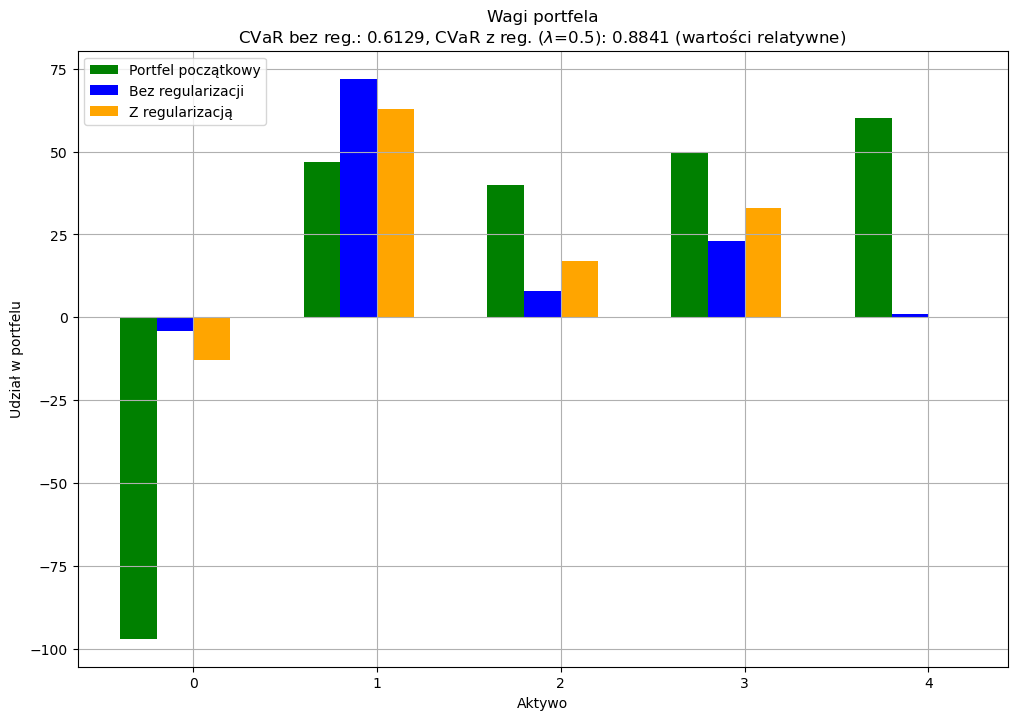

CVaR bez regularizacji: 0.6129 (relatywne)
CVaR z regularizacją ($\lambda$=0.5): 0.8841 (relatywne)


In [11]:
plot_regularization_weights(T_0=T_0,
                             T_f=T_f,
                            max_iter=max_iter,
                            step_size=step_size,
                            annealing_rate=annealing_rate,
                            probabilities=probabilities,
                            alpha=alpha,
                            S_0=S_0,
                            S_T=S_T,
                            V_0=V_0,
                            return_rate=return_rate,
                            regularization_lambda=0.5,
                            initial_portfolio=np.array([20, 30, 40, 50, 60]),
                            relative=True)

### CVar vs. liczba mozliwych scenariuszy

In [12]:
# stan początkowy
S_0_1 = np.array([100, 100, 100, 100, 100])

# stany
S_T_1 = generate_scenarios(S_0_1, number_of_scenarios=1_000_000)

# prawdopodobieństwa
probabilities_1 = 1 / np.arange(1, S_T_1.shape[0] + 1)
# prawdopodobieństwa znormalizowane
probabilities_1 /= probabilities_1.sum()

In [13]:
plot_cvar_history(T_0 = T_0,
                  T_f = T_f,
                  max_iter = max_iter,
                  step_size = step_size,
                  annealing_rate = annealing_rate,
                  probabilities = probabilities_1,
                  alpha = alpha,
                  S_0 = S_0_1,
                  S_T = S_T_1,
                  V_0 = V_0,
                  return_rate = return_rate,
                  n_paths=5)

KeyboardInterrupt: 

<Figure size 1200x800 with 0 Axes>

In [ ]:
plot_cvar_history(T_0 = T_0,
                  T_f = T_f,
                  max_iter = max_iter,
                  step_size = step_size,
                  annealing_rate = annealing_rate,
                  probabilities = probabilities_1,
                  alpha = alpha,
                  S_0 = S_0_1,
                  S_T = S_T_1,
                  V_0 = V_0,
                  return_rate = return_rate,
                  n_paths=5,
                  relative=True)

### Wpływ prawdopodobieństw na wartość CVaR

In [13]:
probabilities_ifluence(T_0=T_0,
                            T_f=T_f,
                          max_iter=max_iter,
                          step_size=step_size,
                          annealing_rate=annealing_rate,
                          probabilities=[probabilities, probabilities_uniform],
                          alpha=alpha,
                          S_0=S_0,
                          S_T=S_T,
                          V_0=V_0,
                          return_rate=return_rate,
                          n_paths=10)

|    | probabilities   |   mean_CVaR |   std_CVaR |
|----|-----------------|-------------|------------|
|  0 | non-uniform     |     6774.08 |    15.1789 |
|  1 | uniform         |   525665.06 |   262.274  |


Zakończono obliczenia dla 100 scenariuszy.
Zakończono obliczenia dla 1000 scenariuszy.


KeyboardInterrupt: 

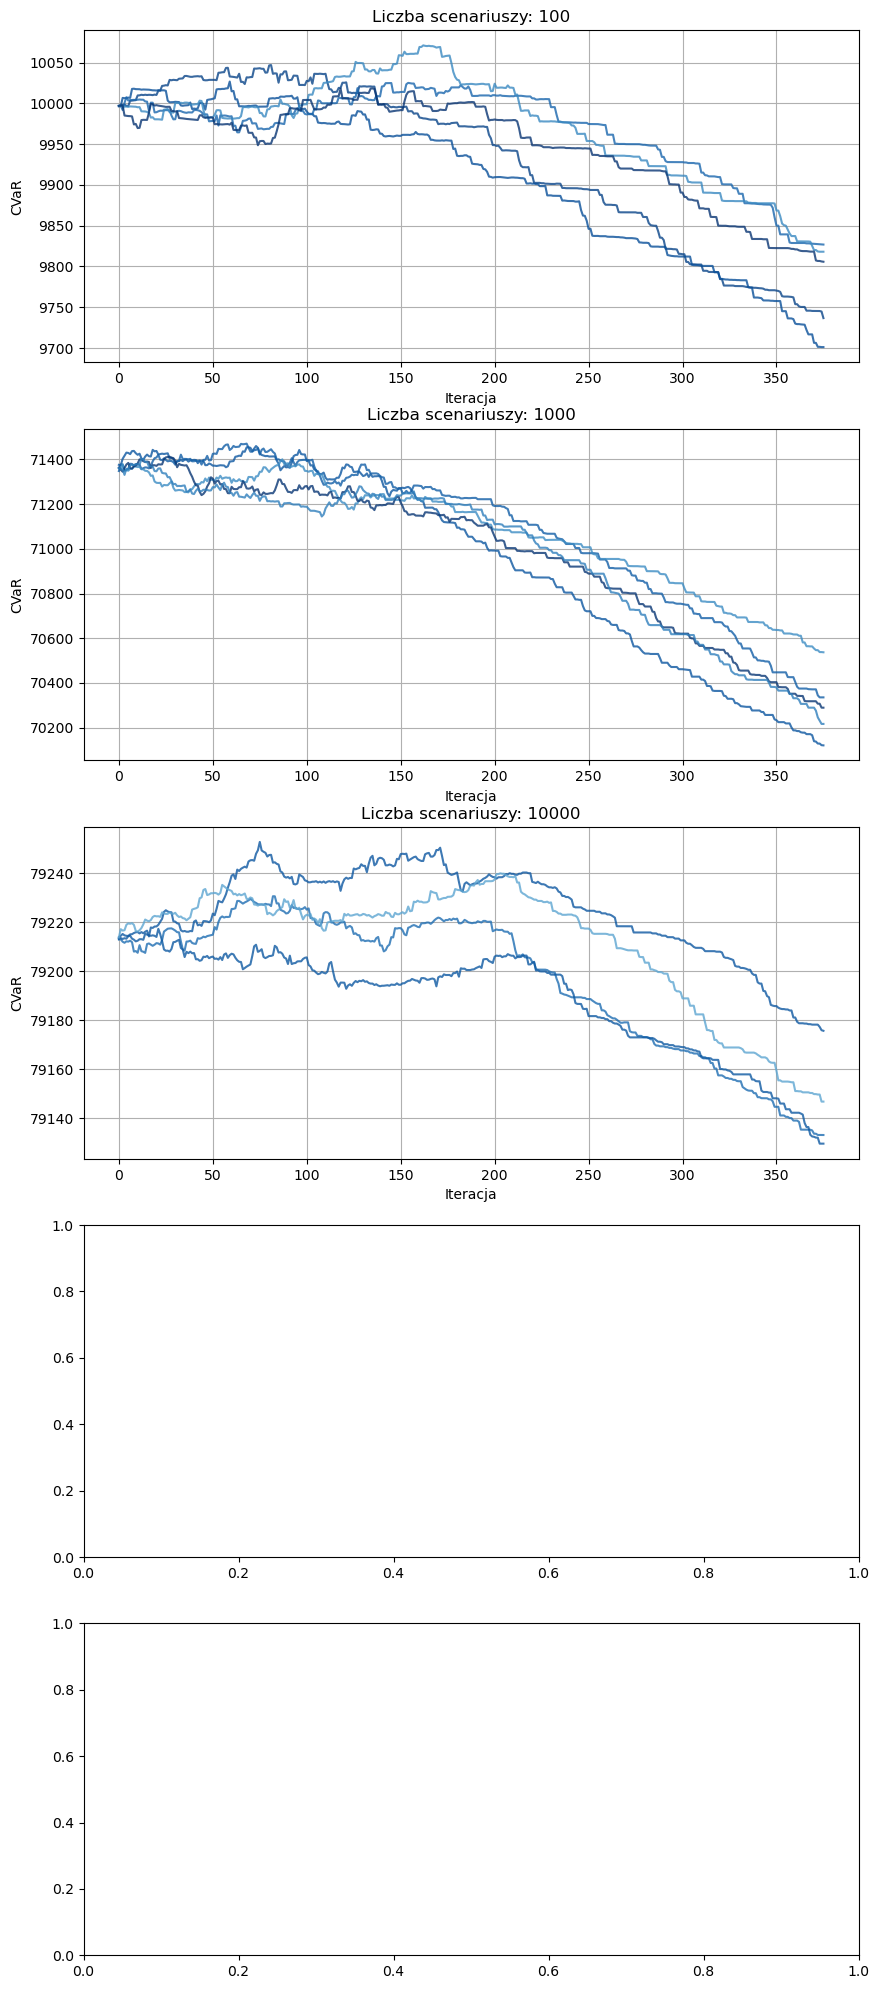

In [15]:
examine_num_of_scenarios_influence(
    T_0=T_0,
    T_f=T_f,
    max_iter=max_iter,
    step_size=step_size,
    annealing_rate=annealing_rate,
    alpha=alpha,
    S_0=S_0,
    S_T=S_T,
    V_0=V_0,
    return_rate=return_rate,
    nums_of_scenarios=[100, 1000, 10000, 100000, 1000_000],
    n_paths=5,
    probabilities='uniform'
)